# 18대 젠더 관련 의안 분석

### 2008.05.30 ~ 2012.05.29 / 노무현, 이명박 정부

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
import hanja
from krwordrank.hangle import normalize
%matplotlib inline

In [2]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [3]:
bill_df = pd.read_csv('/Users/harampark/Documents/research/gender-bill-analysis/data/selenium-data/18대 국회 의안정보.csv', 
                      parse_dates=['제안일자', '의결일자'], index_col=0)

bill_df = bill_df.drop_duplicates()
bill_df.shape

(13913, 9)

In [4]:
def preprocessing(text): 
    text = text.replace('■ 주요내용', ' ').replace('■ 주요골자', ' ').replace('■ 기타사항', ' ').replace('■ 제안경위', ' ')
    text = text.replace('제안이유',' ').replace('주요내용',' ').replace('[',' ').replace(']',' ')
    text = text.replace('참고사항', ' ').replace('■ 위원회 수정이유', ' ').replace('■ 위원회 수정주요내용',' ')
    text = text.replace("'",' ').replace('□ 수정이유',' ').replace('주요골자', ' ').replace('■ 수정사항',' ')
    return text

def clean_name(text): 
    text = text.split('(')[0]
    return text.strip()

In [5]:
%time bill_df['제안이유'] = bill_df['제안이유'].apply(preprocessing)
%time bill_df['의안명'] = bill_df['의안명'].apply(clean_name)

CPU times: user 120 ms, sys: 16.1 ms, total: 136 ms
Wall time: 138 ms
CPU times: user 7.89 ms, sys: 288 µs, total: 8.17 ms
Wall time: 8.13 ms


## 젠더 관련 의안만 추리기

In [6]:
# 여성위원회와 여성가족위원회 함께! 
bill_df['소관위원회'].unique()

array(['여성가족위원회', '문화체육관광방송통신위원회', '국토해양위원회', '지식경제위원회', '농림수산식품위원회',
       '보건복지위원회', '저출산고령화대책특별위원회', '기후변화대응·녹색성장특별위원회', '국회운영위원회',
       '환경노동위원회', '법제사법위원회', '행정안전위원회', '정치개혁특별위원회', '교육과학기술위원회', '정무위원회',
       '기획재정위원회', '국방위원회', '공항·발전소·액화천연가스인수기지주변대책특별위원회', '세계박람회지원특별위원회',
       '외교통상통일위원회', '평창동계올림픽 및 국제경기대회지원특별위원회', '정보위원회', nan,
       '장애인에 대한 성폭력 등 인권침해 방지대책특별위원회', '국제경기대회개최 및 유치지원특별위원회',
       '사법제도개혁특별위원회', '연금제도개선특별위원회', '지방행정체제개편특별위원회', '보건복지가족위원회',
       '기후변화대책특별위원회', '여성위원회', '2012년 여수세계박람회지원특별위원회', '독도영토수호대책특별위원회',
       '국제경기대회지원특별위원회',
       '국제경기대회(세계육상선수권대회, 아시아경기대회, 포뮬러원국제자동차경주대회)지원특별위원회', '규제개혁특별위원회',
       '가축전염병예방법개정특별위원회', '국회법및국회상임위원회위원정수에관한규칙개정특별위원회'], dtype=object)

In [7]:
comm = bill_df[(bill_df['소관위원회'] == '여성위원회')|(bill_df['소관위원회'] == '여성가족위원회')]
comm['의안명'].unique()

array(['청소년 가출예방 및 자립지원에 관한 법률안', '경력단절여성등의 경제활동 촉진법 일부개정법률안',
       '아동·청소년의 성보호에 관한 법률 일부개정법률안', '청소년기본법 일부개정법률안',
       '성폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안', '청소년복지지원법 전부개정법률안',
       '다문화가족지원법 일부개정법률안', '한부모가족지원법 일부개정법률안', '결혼중개업의 관리에 관한 법률 일부개정법률안',
       '비혼 가정의 양육비 및 부양료 확보에 관한 법률안', '가정폭력방지 및 피해자보호 등에 관한 법률 일부개정법률안',
       '청소년보호법 일부개정법률안', '양육비 선지급법안', '건강가정기본법 일부개정법률안', '청소년보호법 전부개정법률안',
       '성매매방지 및 피해자보호 등에 관한 법률 일부개정법률안', '청소년복지지원법 일부개정법률안',
       '가족친화 사회환경의 조성 촉진에 관한 법률 일부개정법률안',
       '건전가정의례의 정착 및 지원에 관한 법률 일부개정법률안', '조손가족지원법안',
       '가족관계의 등록 등에 관한 법률 일부개정법률안', '스카우트활동 육성에 관한 법률 일부개정법률안',
       '한국청소년연맹 육성에 관한 법률 일부개정법률안', '자녀돌봄지원법안', '성별영향분석평가법안',
       '여성발전기본법 전부개정법률안', '여성발전기본법 일부개정법률안', '장애여성지원법안',
       '비혼 자녀의 양육비 지급에 관한 법률안', '인신매매방지 및 피해자보호 등에 관한 법률안',
       '청소년의 인터넷게임중독 예방·해소에 관한 법률안', '청소년활동진흥법 일부개정법률안', '다문화 통합 기본법안',
       '일제하 일본군위안부 피해자에 대한 생활안정지원 및 기념사업 등에 관한 법률 일부개정법률안',
       '성폭력방지 및 피해자보호 등에 관한 법률안'], dtype=object)

In [8]:
keyword = r'.*(여성|성범죄|남녀|호주|육아|보육|가부장|강간|간통죄|성폭력|남녀평등|성차별|모성|성접대|낙태|부녀자|퇴폐|남여|미혼모|\
                성희롱|성보호|음란|윤락|위안부|양성평등|양성 평등|스토킹|가정폭력|정신대|청소년|가정폭력|남녀차별|모자보건|출산|모부자\
                공중화장실|공중 화장실|건강가족기본법|유산|사산|성인지|한부모|모·부자|건강가정|돌봄|성별|다문화|\
                가사노동|가사 노동|결혼중개업|비혼|양육비|가족친화|건전가정|조손가족|가족관계|인신매매|가족법|여교수|산전휴휴가|건강가정).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
gender.shape

(1581, 10)

In [9]:
keyword = r'.*(역차별).*'
glass = gender[gender['의안명'].str.match(keyword) |
           gender['제안이유'].str.match(keyword, flags=re.MULTILINE)]
glass = glass.reset_index()
glass.shape

(0, 11)

In [9]:
# 강간의 범위를 남성피해자도 넓힌다는 것 -> 젠더관련의안인가? 
gender[(gender['의안번호'] == 1800738) | (gender['의안번호'] == 1800582)]

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
1519,1800738,형법 일부개정법률안,2008-08-26,의원,2012-05-29,임기만료폐기,제18대 (2008~2012) 제277회,"최근 성범죄 피해자 중 남성피해자는 2004년 468명에서 2007년 1,04...",법제사법위원회,"['최영희', '김유정', '김종률', '김희철', '노영민', '박은수', '박주..."
1537,1800582,형법 일부개정법률안,2008-08-11,의원,2012-05-29,임기만료폐기,제18대 (2008~2012) 제277회,■ 및 「형법」 제304조의 혼인빙자간음죄를 살펴보면 “혼인을 빙자하거나 ...,법제사법위원회,"['우윤근', '김낙성', '김성곤', '김영진', '김종률', '송민순', '이낙..."


In [10]:
for ind in range(1000, len(gender)): 
    print(gender.loc[ind,'의안번호'])
    print(gender.loc[ind, '의안명'])
    print(gender.loc[ind, '제안이유'])

1806874
열쇠관리법안
   최근 수년간 주택, 사무실, 자동차 등의 잠금장치 등을 해제하고 침입하여 저지르는 절도, 강도, 성범죄 등 일련의 범죄가 증가하고 있어 방범 및 안전에 관한 국민적 관심이 커지고 있음. 강력범죄를 위시한 이러한 범죄는 사후검거도 중요하지만 이를 사전에 효과적으로 방지하기 위한 열쇠 등 관련 분야에 대한 강력한 규제가 필요한 실정임.또한 건축물의 종류와 잠금장치의 설치환경에 따라 방범성능이 상이함에도 불구하고, 선진국과 같은 잠금장치의 방범등급화 등이 마련되어 있지 않아 국민과 사회의 범죄예방 수요에 부응하지 못하고, 국민의 안전 및 방범성능향상에도 미흡한 것이 사실임.따라서 열쇠 자체에 대한 방범성능등급제를 마련하고, 기존 「자격기본법」에 의해 시행되어오던 국가공인 ‘열쇠관리사’ 자격제도를 법제화할 필요가 있음. 또한 등록열쇠업자만이 특수해정도구를 제작, 판매하고 개문 의뢰 시에는 의뢰자의 신원을 확인하고, 장부에 그 확인사항을 기재하도록 하는 등 열쇠 관련 범죄를 효과적으로 예방, 규제할 수 있는 열쇠 관련 관리법안이 필요함. 이런 선진적인 열쇠 관련 관리법안을 통해 열쇠와 관련된 범죄를 사전에 예방하고 효과적으로 관리함으로 국민의 생명·신체 및 재산권을 보호하려는 것임. 가. 이 법은 열쇠의 합리적 관리체계를 통하여 열쇠 등을 부정한 목적으로 사용함으로써 예상되는 범죄를 사전에 예방하여 국민의 생명·신체 및 재산권 보호에 기여함을 목적으로 함(안 제1조).나. 이 법은 「경비업법」에 따른 경비업자에 의하여 운영·관리되는 시설에 설치된 열쇠나 다른 법령에 특별한 규정이 있는 경우에는 적용하지 아니함(안 제6조).다. 행정안전부장관은 열쇠의 안전도 향상 및 소비자보호를 위하여 열쇠방범등급인증제를 시행하여야 하며, 제조업자 또는 외국에서 제조하여 대한민국으로 수출하려는 자는 행정안전부령에 따라 제품별로 인증을 받아야 함(안 제7조).라. 누구든지 인증 받지 아니한 열쇠에 열쇠방범등급에 의한 인증표시 또는 이와 유사한 표시를 해서는

In [11]:
remove_bill = [1814707, 1814700, 1814689, 1814682, 1814671, 1814651, 1814634, 1814629, 1814627, 1814626, 1814623, 
               1814622, 1814620, 1814600, 1814557, 1814492, 1814488, 1814483, 1814479, 1814478, 1814475, 1814470, 
               1814468, 1814462, 1814453, 1814450, 1814447, 1814446, 1814408, 1814374, 1814369, 1814368, 1814367, 
               1814366, 1814357, 1814347, 1814343, 1814332, 1814329, 1814317, 1814302, 1814260, 1814230, 1814215, 
               1814180, 1814069, 1814040, 1814013, 1813995, 1813941, 1813864, 1813855, 1813812, 1813809, 1813807, 
               1813806, 1813783, 1813769, 1813725, 1813719, 1813718, 1813707, 1813697, 1813659, 1813646, 1813577,
               1813564, 1813548, 1813503, 1813490, 1813487, 1813465, 1813460, 1813353, 1813334, 1813328, 1813326, 
               1813317, 1813252, 1813210, 1813202, 1813149, 1813142, 1813104, 1812970, 1812955, 1812891, 1812880, 
               1812857, 1812840, 1812827, 1812806, 1812769, 1812762, 1812740, 1812728, 1812692, 1812660, 1812657, 
               1812618, 1812503, 1812499, 1812493, 1812471, 1812446, 1812441, 1812414, 1812362, 1812357, 1812356, 
               1812350, 1812319, 1812302, 1812271, 1812262, 1812249, 1812234, 1812210, 1812159, 1812156, 1812115,
               1812109, 1812091, 1812077, 1812056, 1812027, 1811904, 1811899, 1811871, 1811870, 1811868, 1811867, 
               1811858, 1811843, 1811811, 1811809, 1811800, 1811785, 1811782, 1811777, 1811759, 1811731, 1811727, 
               1811700, 1811684, 1811644, 1811640, 1811611, 1811608, 1811597, 1811521, 1811520, 1811510, 1811506, 
               1811501, 1811484, 1811447, 1811397, 1811388, 1811361, 1811355, 1811342, 1811340, 1811339, 1811335, 
               1811329, 1811284, 1811258, 1811246, 1811245, 1811240, 1811238, 1811237, 1811235, 1811234, 1811224, 
               1811215, 1811214, 1811213, 1811175, 1811174, 1811171, 1811155, 1811154, 1811149, 1811146, 1811140, 
               1811129, 1811127, 1811122, 1811112, 1811094, 1811089, 1811079, 1811078, 1811056, 1811052, 1811049, 
               1811019, 1810992, 1810988, 1810984, 1810937, 1810925, 1810916, 1810881, 1810867, 1810845, 1810815, 
               1810801, 1810795, 1810789, 1810761, 1810750, 1810728, 1810706, 1810701, 1810681, 1810670, 1810619, 
               1810604, 1810603, 1810602, 1810597, 1810584, 1810555, 1810526, 1810516, 1810499, 1810459, 1810448,
               1810439, 1810419, 1810371, 1810360, 1810359, 1810358, 1810304, 1810297, 1810284, 1810277, 1810271, 
               1810262, 1810256, 1810237, 1810210, 1810207, 1810204, 1810196, 1810186, 1810169, 1810133, 1810085,
               1810052, 1810036, 1810029, 1810026, 1810013, 1809989, 1809976, 1809878, 1809866, 1809840, 1809839, 
               1809827, 1809788, 1809787, 1809783, 1809764, 1809760, 1809740, 1809704, 1809703, 1809645, 1809641, 
               1809618, 1809617, 1809609, 1809562, 1809530, 1809529, 1809519, 1809513, 1809509, 1809493, 1809419, 
               1809418, 1809300, 1809266, 1809259, 1809252, 1809243, 1809242, 1809234, 1809226, 1809220, 1809216, 
               1809215, 1809205, 1809204, 1809176, 1809105, 1809102, 1809086, 1808965, 1808936, 1808929, 1808915, 
               1808894, 1808848, 1808830, 1808790, 1808788, 1808679, 1808661, 1808597, 1808582, 1808567, 1808556, 
               1808547, 1808541, 1808534, 1808533, 1808531, 1808524, 1808495, 1808481, 1808470, 1808458, 1808453, 
               1808450, 1808449, 1808403, 1808389, 1808383, 1808330, 1808323, 1808309, 1808303, 1808302, 1808299, 
               1808296, 1808292, 1808270, 1808241, 1808215, 1808191, 1808154, 1808150, 1808134, 1808132, 1808113, 
               1808101, 1808099, 1808098, 1808095, 1808084, 1808068, 1808037, 1808033, 1807994, 1807993, 1807988, 
               1807959, 1807914, 1807862, 1807849, 1807839, 1807817, 1807800, 1807771, 1807760, 1807733, 1807732,
               1807711, 1807694, 1807666, 1807645, 1807610, 1807547, 1807544, 1807517, 1807492, 1807491, 1807423, 
               1807393, 1807385, 1807383, 1807379, 1807378, 1807377, 1807376, 1807283, 1807254, 1807154, 1807150, 
               1807097, 1807081, 1807080, 1807046, 1807041, 1807022, 1806956, 1806953, 1806895, 1806894,
               1806874, 1806857, 1806834, 1806819, 1806802, 1806795, 1806746, 1806740, 1806700, 1806698, 1806663, 
               1806639, 1806631, 1806621, 1806605, 1806549, 1806546, 1806439, 1806431, 1806411, 1806384, 1806367, 
               1806363, 1806358, 1806349, 1806348, 1806346, 1806345, 1806334, 1806298, 1806297, 1806284, 1806256, 
               1806253, 1806174, 1806162, 1806130, 1806125, 1806072, 1806059, 1806045, 1805970, 1805952, 1805925, 
               1805897, 1805852, 1805844, 1805781, 1805752, 1805750, 1805739, 1805721, 1805715, 1805714, 1805705, 
               1805646, 1805550, 1805532, 1805492, 1805488, 1805447, 1805425, 1805388, 1805367, 1805364, 1805338, 
               1805337, 1805333, 1805332, 1805249, 1805241, 1805222, 1805213, 1805158, 1805145, 1805122, 1805111, 
               1805110, 1805098, 1805070, 1805048, 1805009, 1804940, 1804932, 1804896, 1804871, 1804832, 1804805, 
               1804804, 1804795, 1804770, 1804694, 1804667, 1804656, 1804612, 1804595, 1804589, 1804562, 1804521, 
               1804519, 1804471, 1804461, 1804459, 1804458, 1804457, 1804456, 1804455, 1804454, 1804453, 1804452, 
               1804451, 1804450, 1804449, 1804448, 1804447, 1804446, 1804445, 1804444, 1804443, 1804442, 1804441, 
               1804440, 1804439, 1804437, 1804436, 1804434, 1804431, 1804430, 1804428, 1804427, 1804426, 1804425, 
               1804423, 1804422, 1804421, 1804420, 1804419, 1804418, 1804417, 1804416, 1804414, 1804413, 1804412, 
               1804411, 1804410, 1804362, 1804313, 1804281, 1804250, 1804209, 1804199, 1804193, 1804124, 1804091, 
               1804005, 1803979, 1803956, 1803944, 1803925, 1803924, 1803888, 1803886, 1803867, 1803865, 1803856, 
               1803828, 1803824, 1803814, 1803813, 1803810, 1803781, 1803752, 1803740, 1803739, 1803728, 1803693, 
               1803692, 1803686, 1803685, 1803637, 1803624, 1803618, 1803617, 1803581, 1803569, 1803561, 1803560, 
               1803543, 1803525, 1803495, 1803489, 1803433, 1803416, 1803397, 1803369, 1803369, 1803366, 1803356, 
               1803261, 1803248, 1803247, 1803242, 1803229, 1803215, 1803205, 1803197, 1803176, 1803161, 1803111, 
               1803083, 1803037, 1803036, 1803033, 1803022, 1803021, 1803020, 1803014, 1803011, 1802978, 1802977, 
               1802941, 1802923, 1802921, 1802897, 1802888, 1802880, 1802875, 1802833, 1802827, 1802818, 1802763, 
               1802712, 1802705, 1802700, 1802699, 1802698, 1802697, 1802696, 1802695, 1802657, 1802529, 1802491, 
               1802486, 1802389, 1802340, 1802332, 1802330, 1802323, 1802317, 1802304, 1802303, 1802302, 1802253, 
               1802234, 1802233, 1802232, 1802207, 1802162, 1802085, 1802039, 1802019, 1802007, 1801967, 1801893, 
               1801891, 1801883, 1801882, 1801875, 1801872, 1801869, 1801867, 1801849, 1801794, 1801744, 1801731, 
               1801694, 1801683, 1801681, 1801677, 1801651, 1801645, 1801630, 1801617, 1801569, 1801472, 1801465, 
               1801418, 1801411, 1801406, 1801405, 1801404, 1801403, 1801402, 1801401, 1801363, 1801235, 1801197,
               1801192, 1801117, 1801088, 1801071, 1801069, 1801063, 1801055, 1801053, 1800993, 1800947, 1800942, 
               1800926, 1800908, 1800880, 1800875, 1800827, 1800822, 1800820, 1800807, 1800801, 1800791, 1800786, 
               1800679, 1800673, 1800667, 1800651, 1800641, 1800640, 1800614, 1800611, 1800597, 1800577, 1800538, 
               1800517, 1800474, 1800443, 1800442, 1800435, 1800434, 1800396, 1800356, 1800355, 1800304, 1800290, 
               1800255, 1800245, 1800222, 1800213, 1800187, 1800183, 1800123, 1800115, 1800113, 1800112, 1800105, 
               1800099, 1800089, 1800014, 1800013
               ]
gender = gender[~gender['의안번호'].isin(remove_bill)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(820, 10)

In [12]:
gender.to_csv('18th-gender-bill.csv',encoding='utf-8-sig')

## wordcloud 시각화

In [16]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [17]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [18]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 83.4 ms, sys: 2.57 ms, total: 86 ms
Wall time: 87.4 ms


In [19]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [20]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 54.7 s, sys: 814 ms, total: 55.6 s
Wall time: 40.8 s


0    [청소년, 가출예방, 자립지원, 법률안, 빈곤, 부모, 이혼, 가정폭력, 학대, 학...
1    [저출산, 고령사회기본법, 일부개정법률안, 법률안, 심사한, 결과, 국회, 임시회,...
2    [모자보건법, 일부개정법률안, 법률안, 심사한, 결과, 국회, 임시회, 전체회의, ...
Name: tokens, dtype: object

In [21]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 205 ms, sys: 4.03 ms, total: 209 ms
Wall time: 213 ms


In [22]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [23]:
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-22 14:04:26,522 : INFO : collecting all words and their counts
2020-09-22 14:04:26,523 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-22 14:04:26,542 : INFO : collected 10373 word types from a corpus of 85448 raw words and 820 sentences
2020-09-22 14:04:26,543 : INFO : Loading a fresh vocabulary
2020-09-22 14:04:26,550 : INFO : effective_min_count=10 retains 1451 unique words (13% of original 10373, drops 8922)
2020-09-22 14:04:26,551 : INFO : effective_min_count=10 leaves 64809 word corpus (75% of original 85448, drops 20639)
2020-09-22 14:04:26,557 : INFO : deleting the raw counts dictionary of 10373 items
2020-09-22 14:04:26,558 : INFO : sample=0.001 downsamples 62 most-common words
2020-09-22 14:04:26,558 : INFO : downsampling leaves estimated 56650 word corpus (87.4% of prior 64809)
2020-09-22 14:04:26,562 : INFO : estimated required memory for 1451 words and 100 dimensions: 1886300 bytes
2020-09-22 14:04:26,564 : INFO : resetting layer 

2020-09-22 14:04:27,608 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 14:04:27,610 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 14:04:27,611 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-22 14:04:27,612 : INFO : EPOCH - 15 : training on 85448 raw words (56658 effective words) took 0.0s, 1463888 effective words/s
2020-09-22 14:04:27,651 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-22 14:04:27,659 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 14:04:27,660 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 14:04:27,661 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-22 14:04:27,662 : INFO : EPOCH - 16 : training on 85448 raw words (56593 effective words) took 0.0s, 1192579 effective words/s
2020-09-22 14:04:27,702 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-09-22 14:04:28,498 : INFO : EPOCH - 31 : training on 85448 raw words (56612 effective words) took 0.0s, 1268449 effective words/s
2020-09-22 14:04:28,539 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-22 14:04:28,544 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 14:04:28,545 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 14:04:28,546 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-22 14:04:28,547 : INFO : EPOCH - 32 : training on 85448 raw words (56617 effective words) took 0.0s, 1278342 effective words/s
2020-09-22 14:04:28,586 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-22 14:04:28,590 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 14:04:28,592 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 14:04:28,593 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2020-09-22 14:04:29,276 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 14:04:29,282 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 14:04:29,284 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-22 14:04:29,285 : INFO : EPOCH - 48 : training on 85448 raw words (56679 effective words) took 0.0s, 1323705 effective words/s
2020-09-22 14:04:29,330 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-22 14:04:29,335 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 14:04:29,336 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 14:04:29,337 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-22 14:04:29,338 : INFO : EPOCH - 49 : training on 85448 raw words (56767 effective words) took 0.1s, 1128735 effective words/s
2020-09-22 14:04:29,375 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-09-22 14:04:30,137 : INFO : EPOCH - 64 : training on 85448 raw words (56592 effective words) took 0.0s, 1430590 effective words/s
2020-09-22 14:04:30,175 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-22 14:04:30,178 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 14:04:30,181 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 14:04:30,182 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-22 14:04:30,183 : INFO : EPOCH - 65 : training on 85448 raw words (56638 effective words) took 0.0s, 1337956 effective words/s
2020-09-22 14:04:30,222 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-22 14:04:30,226 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 14:04:30,227 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 14:04:30,229 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2020-09-22 14:04:31,092 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 14:04:31,094 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 14:04:31,096 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-22 14:04:31,097 : INFO : EPOCH - 81 : training on 85448 raw words (56591 effective words) took 0.0s, 1202386 effective words/s
2020-09-22 14:04:31,182 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-22 14:04:31,186 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 14:04:31,190 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 14:04:31,191 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-22 14:04:31,194 : INFO : EPOCH - 82 : training on 85448 raw words (56700 effective words) took 0.1s, 614464 effective words/s
2020-09-22 14:04:31,285 : INFO : worker thread finished; awaiting finish of 3 more threads
202

2020-09-22 14:04:32,318 : INFO : EPOCH - 97 : training on 85448 raw words (56578 effective words) took 0.1s, 1075564 effective words/s
2020-09-22 14:04:32,374 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-22 14:04:32,380 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 14:04:32,382 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 14:04:32,384 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-22 14:04:32,385 : INFO : EPOCH - 98 : training on 85448 raw words (56600 effective words) took 0.1s, 968269 effective words/s
2020-09-22 14:04:32,433 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-22 14:04:32,438 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 14:04:32,440 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 14:04:32,445 : INFO : worker thread finished; awaiting finish of 0 more threads
202

In [24]:
print(model.wv.most_similar('여성'))
print(model.wv.most_similar('청소년'))

2020-09-22 14:04:32,521 : INFO : precomputing L2-norms of word weight vectors


[('여성들', 0.49245110154151917), ('경제활동', 0.42873966693878174), ('참여', 0.38974907994270325), ('사회활동', 0.37026262283325195), ('단절', 0.3607516288757324), ('유산', 0.3586975634098053), ('직장생활', 0.3468993902206421), ('정치참여', 0.3446006178855896), ('저하', 0.3339334726333618), ('배우자', 0.32889556884765625)]
[('아동', 0.5868806838989258), ('성범죄자', 0.541206419467926), ('성범죄', 0.4693520963191986), ('친권자', 0.44471076130867004), ('유죄판결', 0.4202992916107178), ('청소년대상', 0.4060927629470825), ('노무', 0.4033525586128235), ('인터넷', 0.40185868740081787), ('취업제한', 0.3968191146850586), ('성보호', 0.38843441009521484)]


In [25]:
gender['tokens']

0      [청소년, 가출예방, 자립지원, 법률안, 빈곤, 부모, 이혼, 가정폭력, 학대, 학...
1      [저출산, 고령사회기본법, 일부개정법률안, 법률안, 심사한, 결과, 국회, 임시회,...
2      [모자보건법, 일부개정법률안, 법률안, 심사한, 결과, 국회, 임시회, 전체회의, ...
3      [유아교육법, 일부개정법률안, 대안, 제안경위, 원희목의원, 안민석의원, 권영진의원...
4      [보조생식, 법률안, 현재, 보조생식, 시술, 증가, 보조생식, 생명윤리, 법률, ...
                             ...                        
815    [성폭력범죄, 처벌, 피해자보호, 법률, 일부개정법률안, 성폭력범죄, 피해자, 미성...
816    [공무원연금법, 일부개정법률안, 현행법, 유족급여, 손자녀, 범위, 정의함, 미만,...
817    [군인연금법, 일부개정법률안, 현행법, 군인, 사망, 유족급여, 손자녀, 범위, 정...
818    [사립학교교직원, 연금법, 일부개정법률안, 사립학교교원, 사무직원, 사망, 유족급여...
819    [공직선거법, 일부개정법률안, 지방선거, 현행, 공직선거법, 기초지방자치단체, 의원...
Name: tokens, Length: 820, dtype: object

In [26]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [27]:
gender_word = total_tokens(gender['tokens'])

In [28]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','규정함','본회','수립','항제', '의결제','촉진','의결',
            '영역','도모','확대','구현','이외','원안폐','조등']
gender_word = [each_word for each_word in gender_word if each_word not in stopwords]

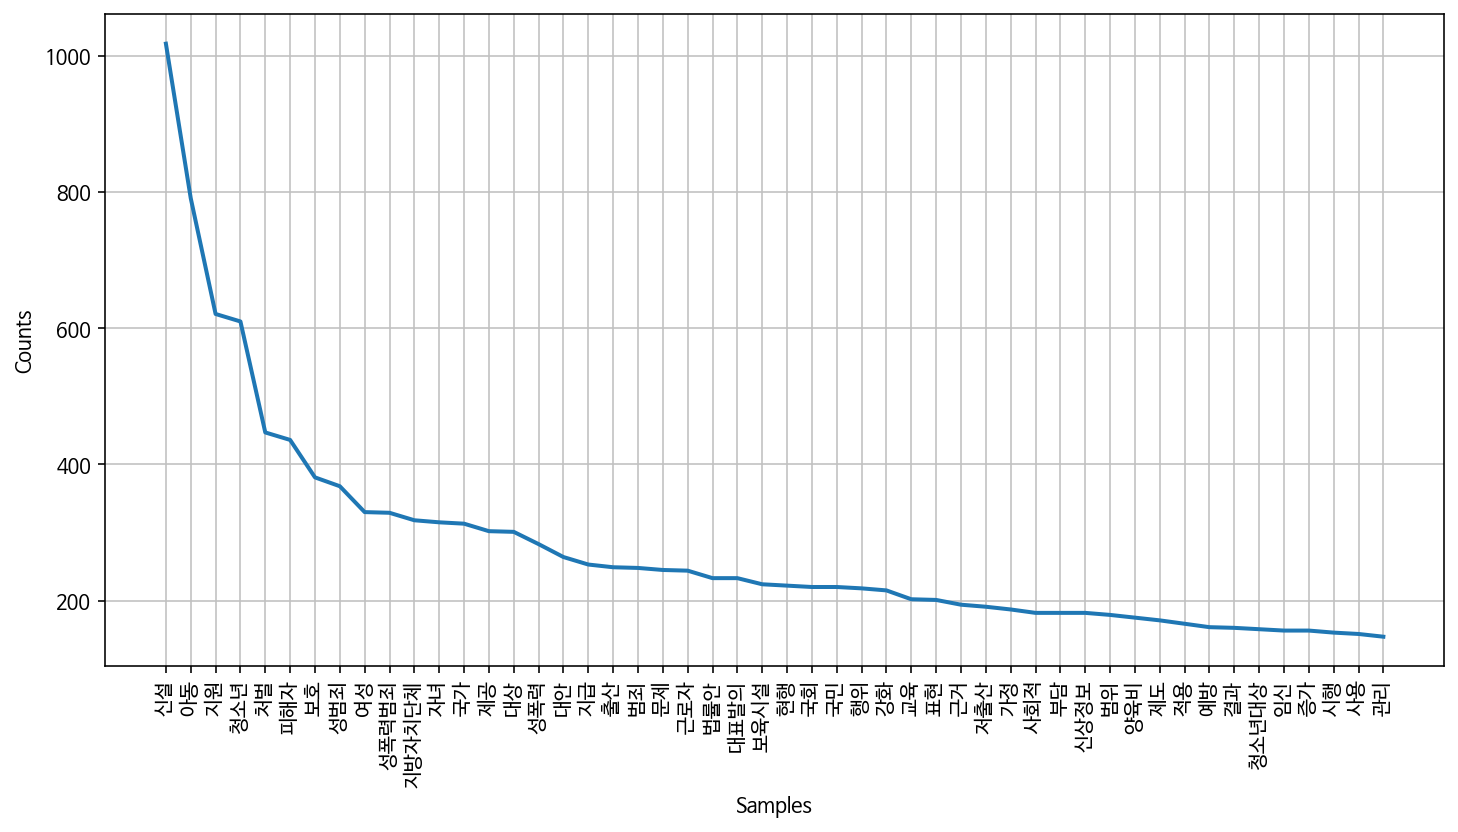

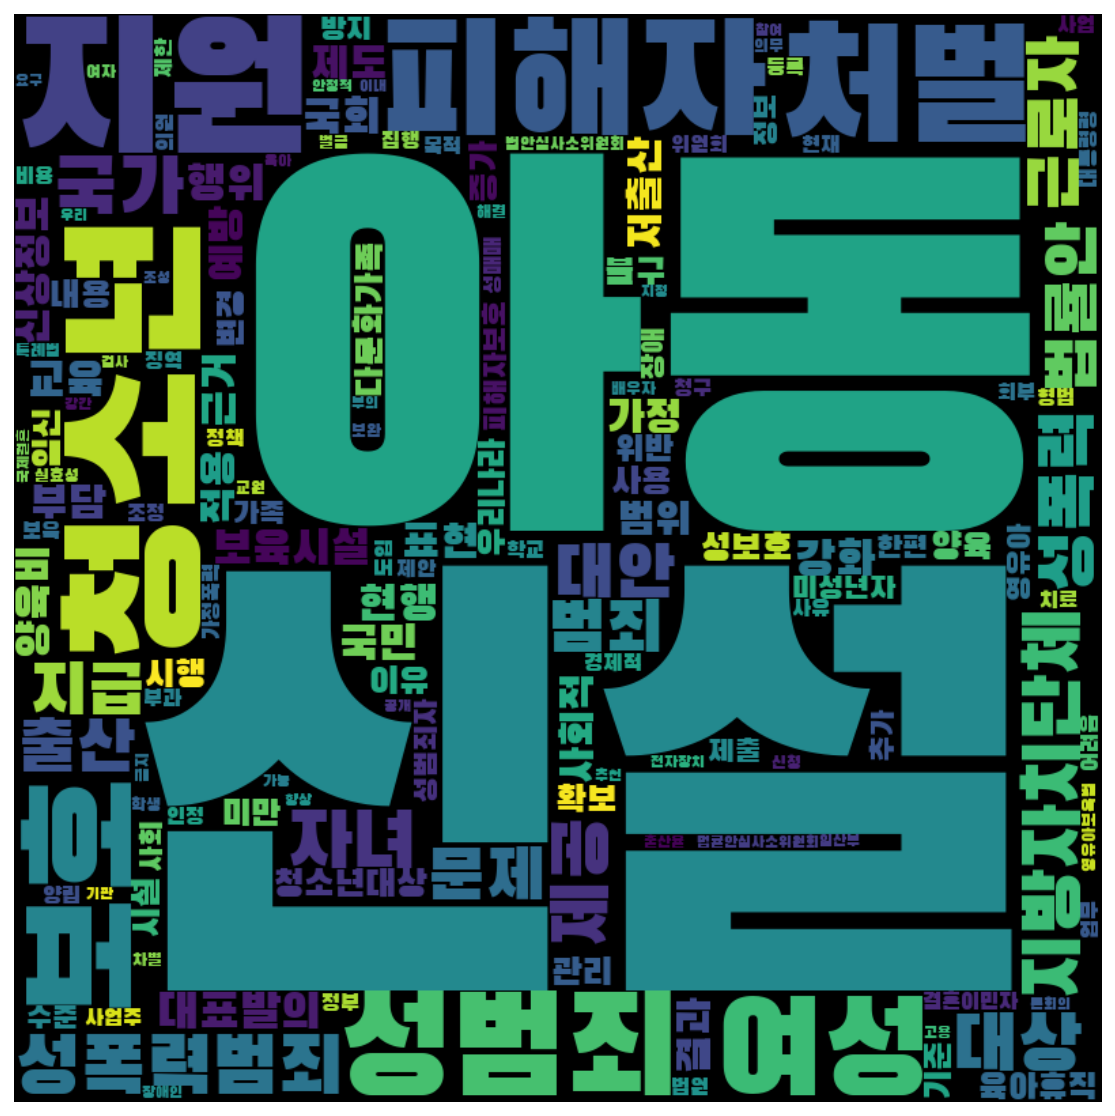

In [29]:
frewords_vis(gender_word)
wordcloud_vis(gender_word)